### Many of the graphs are interactive; users can run the code in their notebook to hover over the graphs for details
##### Graph made with Bokeh library don't display in the notebook uploaded to GitHub
##### Graph for part 7 renders outside the notebook

In [185]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from matplotlib.font_manager import FontProperties
import plotly
import numpy as np

import random
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from termcolor import colored
from IPython.display import display
from numpy import pi

from simple_colors import *
from plotly.graph_objs import *
init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None

In [186]:
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show

from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel

from bokeh.plotting import figure
from bokeh.io import show, output_notebook

from ipywidgets import interact, interact_manual
from bokeh.models import Legend, LegendItem

from bokeh.transform import cumsum
from bokeh.palettes import Spectral

from bokeh.palettes import RdBu3
from bokeh.palettes import Category20c

from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource
from bokeh.models import FactorRange
from bokeh.models import LabelSet

output_notebook()

Loading BokehJS ...

### Part 1: Exploratory Data Analysis

In [187]:
def read_data(path, filename):
    allegations_df = pd.read_csv(path + "\\" + filename)    
    
    return allegations_df

In [188]:
path = r'C:\Users\Prabhat\Desktop\python progs'
filename = "allegations_20200726939.csv"

allegations_df = read_data(path, filename)

print ("The data types of columns are \n")
display(allegations_df.dtypes)

print("\n A look at the first 4 rows of the data\n")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(allegations_df.head(4))

print(blue("\nThe dimensions of dataframe are {}", ['bold']).format(allegations_df.shape))

The data types of columns are 



unique_mos_id                 int64
first_name                   object
last_name                    object
command_now                  object
complaint_id                  int64
month_received                int64
year_received                 int64
month_closed                  int64
year_closed                   int64
command_at_incident          object
rank_abbrev_incident         object
rank_abbrev_now              object
rank_now                     object
rank_incident                object
mos_ethnicity                object
mos_gender                   object
mos_age_incident              int64
complainant_ethnicity        object
complainant_gender           object
complainant_age_incident    float64
fado_type                    object
allegation                   object
precinct                    float64
contact_reason               object
outcome_description          object
board_disposition            object
dtype: object


 A look at the first 4 rows of the data

   unique_mos_id first_name last_name command_now  complaint_id  \
0          10004   Jonathan      Ruiz     078 PCT         42835   
1          10007       John     Sears     078 PCT         24601   
2          10007       John     Sears     078 PCT         24601   
3          10007       John     Sears     078 PCT         26146   

   month_received  year_received  month_closed  year_closed  \
0               7           2019             5         2020   
1              11           2011             8         2012   
2              11           2011             8         2012   
3               7           2012             9         2013   

  command_at_incident rank_abbrev_incident rank_abbrev_now        rank_now  \
0             078 PCT                  POM             POM  Police Officer   
1                PBBS                  POM             POM  Police Officer   
2                PBBS                  POM             POM  Police Offic

In [189]:
def eda_one(allegations_df):
    '''
    preliminary EDA
    '''   
    # the oldest complaint dates back to 1985, and the latest to 2020
    # the oldest complainant is 101 years old
    # there are some negative age values for complainants, which will be dealt with at an appropriate stage
    # the oldest officer to face a complaint is 60 years old, and the youngest 20
    allegations_df.describe()
    
    # 5 columns dropped
    allegations_df = allegations_df.drop(['command_now', 'command_at_incident', 
                                          'rank_abbrev_incident', 'rank_abbrev_now', 'precinct'], axis = 1)
    
    # check for NA
    allegations_df.isna().sum()
    
    
    print(blue("\nThere are {} unique officers in the data set\n\n", ['bold']).format(allegations_df['unique_mos_id'].nunique()))
    print ("On average, each officer faces over 8 complaints\n\n")
    print (green("There are {} unique complaints in the data set\n\n", ['bold']).format(allegations_df['complaint_id'].nunique()))
    print ("On average, a complaint mentions nearly 3 separate offences (an offence could involve the same or different officers)\n\n")

In [190]:
def eda_two(allegations_df):
    '''
    slightly more advanced EDA
    '''

    total_rows = allegations_df.shape[0]
    print(yellow("{}% of complaints are against White officers, {}% against Hispanic & {}% against Black officers (chart below)\n", \
                 ['bold']).format(int(100*(allegations_df[allegations_df['mos_ethnicity'] == 'White'].shape[0])/total_rows), \
      int(100*(allegations_df[allegations_df['mos_ethnicity'] == 'Hispanic'].shape[0])/total_rows), \
      int(100*(allegations_df[allegations_df['mos_ethnicity'] == 'Black'].shape[0])/total_rows)))

    ax1 = allegations_df['mos_ethnicity'].value_counts().plot(kind='bar')
    ax1.grid(False)
    plt.show()
    
    total_rows_wo_na = allegations_df[allegations_df['complainant_ethnicity'].notna()].shape[0]
    print(blue("Dropping NA values, {}% of complaints are by Black people, {}% by Hispanic & {}% by White people (chart below)\n", \
               ['bold']).format(int(100*(allegations_df[allegations_df['complainant_ethnicity'] == 'Black'].shape[0])/total_rows_wo_na),\
      int(100*(allegations_df[allegations_df['complainant_ethnicity'] == 'Hispanic'].shape[0])/total_rows_wo_na), 
      int(100*(allegations_df[allegations_df['complainant_ethnicity'] == 'White'].shape[0])/total_rows_wo_na)))

    ax2 = allegations_df['complainant_ethnicity'].value_counts().plot(kind='bar', color = 'green')
    ax2.grid(False)
    plt.show()    
    print (green("No arrest is made by the officer in {}% of cases (chart below) \n", ['bold']).
           format(int(100*(allegations_df[allegations_df['outcome_description'] == 'No arrest made or summons issued'].
                           shape[0])/allegations_df.shape[0])))
    
    ax3 = allegations_df['outcome_description'].value_counts().plot(kind='bar')
    ax3.grid(False)
    plt.show()
    
    # About 2/3 complaints were made against officers with the rank Police Officer, 18% against Sergeants
    by_off_rank_df = allegations_df.groupby('rank_incident').size().reset_index(name = 'number_of_complaints')

    ax4 = plt.subplot(121, aspect='equal')
    ax4.pie(by_off_rank_df['number_of_complaints'], autopct='%.0f%%',  startangle=10)
    ax4.axis('equal')
    plt.legend(labels = by_off_rank_df['rank_incident'], loc="best")
    plt.tight_layout()    
    plt.title("Share of complaints by officer rank", bbox={'facecolor':'0.8', 'pad':2})
    ax4 = plt.gcf()
    ax4.set_size_inches(7,7)
    plt.show()
    
    # FADO: Force, Abuse of Authority, Discourtesy, Offensive Language
    # 23% complaints involved alleged use of force by officers

    by_fado_df = allegations_df.groupby('fado_type').size().reset_index(name = 'number_of_complaints')

    ax5 = plt.subplot(121, aspect='equal')
    ax5.pie(by_fado_df['number_of_complaints'], autopct='%.0f%%',  startangle=10)
    ax5.axis('equal')
    plt.legend(labels = by_fado_df['fado_type'], loc="best")
    plt.tight_layout()    
    plt.title("Share of complaints by type", bbox={'facecolor':'0.8', 'pad':2})
    ax5 = plt.gcf()
    ax5.set_size_inches(7,7) 
    plt.show()
    
    print(yellow("The board either exonerates or fails to substantiate complaint in {}% of cases (chart below) \n", ['bold']).
      format(int(100*(allegations_df[(allegations_df['board_disposition'] == 'Unsubstantiated') | 
                              (allegations_df['board_disposition'] == 'Exonerated')].shape[0])/allegations_df.shape[0])))
    
    by_verdict_df = allegations_df.groupby('board_disposition').size().reset_index(name = 'number_of_complaints') \
    .sort_values('number_of_complaints', ascending = False)
    labels = list(by_verdict_df['board_disposition'].unique())
    ax6 = sns.barplot(x = 'board_disposition', y = 'number_of_complaints', data = by_verdict_df)
    ax6.set_xticklabels(rotation=90, labels = labels)
    ax6.grid(False) 
    plt.show()
    print ("\n\n\n")
    return total_rows


There are 3996 unique officers in the data set


On average, each officer faces over 8 complaints


There are 12056 unique complaints in the data set


On average, a complaint mentions nearly 3 separate offences (an offence could involve the same or different officers)


54% of complaints are against White officers, 27% against Hispanic & 14% against Black officers (chart below)



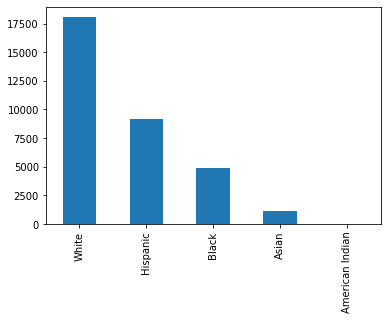

Dropping NA values, 59% of complaints are by Black people, 22% by Hispanic & 9% by White people (chart below)



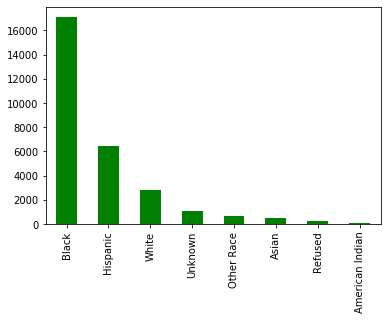

No arrest is made by the officer in 38% of cases (chart below) 



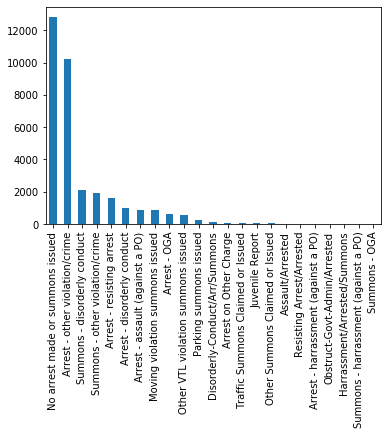

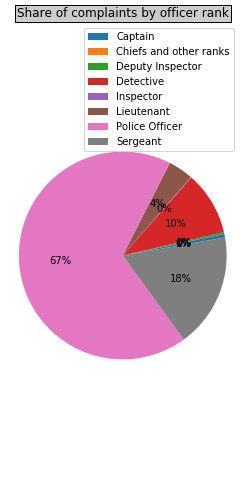

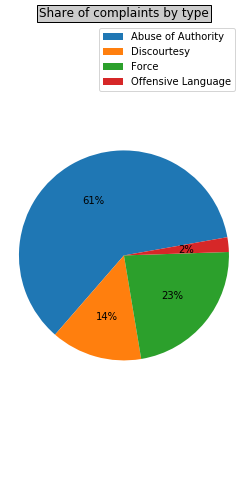

The board either exonerates or fails to substantiate complaint in 75% of cases (chart below) 



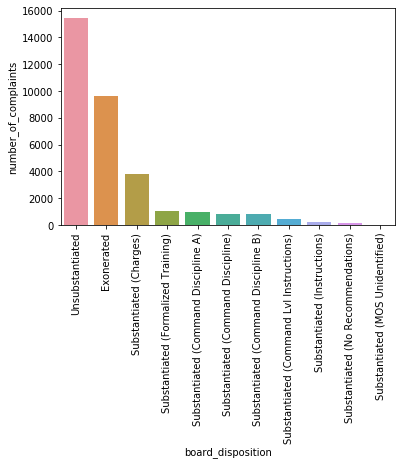

In [191]:
eda_one(allegations_df)
total_rows = eda_two(allegations_df)

#### Before proceeding to Part 2, please execute the next cell

##### These two functions (written at the bottom of the code) assign numerical values to officers' ranks and the Board's findings, which will allow further analyses

In [192]:
allegations_df_rank = numeric_rank(allegations_df)
allegations_df_rank_board = numeric_board_disposition(allegations_df_rank)

##### I have assigned values to ranks in ascending order as per NYPD hierarchy (https://nypd.fandom.com/wiki/NYPD_Uniforms_and_Ranks)

##### {'Police Officer': 0, 'Detective': 1, 'Sergeant': 2, 'Lieutenant': 3, 'Captain': 4, 'Deputy Inspector': 5, 'Inspector': 6, 'Chiefs and other ranks': 7}

##### Among the board findings (board_disposition) both Unsubstantiated and Exonerated have been assigned 0 
##### The several different forms of Substantiated findings - charges, command discipline etc. - have all been assigned 1

### Part 2. How about White cops-Black people?
####                        &
###         Male cops - Women?

##### This part tries to answer the above two questions through an interactive pie chart

In [193]:
def ethnicity_calculations(allegations_df):
    '''
    calculates distribution of complaints by complainants' race, for officers from different races
    '''
    
    # comp_ethnicity_df contains share of complaints by race of complainant for all officers (NaN values dropped)
    comp_ethnicity_df = allegations_df[allegations_df['complainant_ethnicity'].notna()].groupby('complainant_ethnicity').size() \
    .reset_index(name='total_complaints').sort_values('total_complaints', ascending = False)
    
    comp_ethnicity_df['percentage_of_overall_complaints'] = round(comp_ethnicity_df['total_complaints']*100/allegations_df \
                                                                  [allegations_df['complainant_ethnicity'].notna()].shape[0],1)
    
    # off_ethnicity_df contains share of complaints by race of officer
    off_ethnicity_df = allegations_df[allegations_df['complainant_ethnicity'].notna()].groupby('mos_ethnicity').size() \
    .reset_index(name='number_of_complaints').sort_values('number_of_complaints', ascending = False)
    
    off_ethnicity_df['percentage_of_complaints'] = round(off_ethnicity_df['number_of_complaints']*100/allegations_df \
                                                         [allegations_df['complainant_ethnicity'].notna()].shape[0],1)
    
    # off_comp_ethnicity_df contains number of complaints by race of complainant, for each different race of officer
    off_comp_ethnicity_df = allegations_df.groupby(['complainant_ethnicity', 'mos_ethnicity']).size().reset_index \
    (name='number_of_complaints')

    # merge the above two dataframes to calculate share of complaints by race of complainant, for officers of each different race
    merge_race_df = comp_ethnicity_df.merge(off_comp_ethnicity_df,on='complainant_ethnicity').merge(off_ethnicity_df,on='mos_ethnicity')
    
    merge_race_df['percentage_of_complaints'] = round(merge_race_df['number_of_complaints_x']*100/merge_race_df['number_of_complaints_y'],1)
    
    # retaining only the relevant columns
    merge_race_df = merge_race_df[['mos_ethnicity', 'complainant_ethnicity', 'percentage_of_complaints', 'percentage_of_overall_complaints']]
    
    return merge_race_df

In [194]:
def gender_calculations(allegations_df):
    '''
    calculates distribution of complaints by complainants' gender, for officers from different genders
    based on a logic similar to the above function ethnicity_calculations
    '''
    
    comp_gender_df = allegations_df[allegations_df['complainant_gender'].notna()].groupby('complainant_gender').size().reset_index \
    (name='total_complaints').sort_values('total_complaints', ascending = False)
    
    comp_gender_df['percentage_of_overall_complaints'] = round(comp_gender_df['total_complaints']*100/allegations_df[allegations_df \
                                                               ['complainant_gender'].notna()].shape[0],1)
    
    off_comp_gender_df = allegations_df.groupby(['complainant_gender', 'mos_gender']).size().reset_index(name='number_of_complaints')
    
    off_gender_df = allegations_df[allegations_df['complainant_gender'].notna()].groupby('mos_gender').size().reset_index \
    (name='number_of_complaints').sort_values('number_of_complaints', ascending = False)
    
    off_gender_df['percentage_of_complaints'] = round(off_gender_df['number_of_complaints']*100/allegations_df.shape[0],1)
    
    merge_gender_df = comp_gender_df.merge(off_comp_gender_df,on='complainant_gender').merge(off_gender_df,on='mos_gender')
    
    merge_gender_df['percentage_of_complaints'] = round(merge_gender_df['number_of_complaints_x']*100/merge_gender_df \
                                                                                         ['number_of_complaints_y'],1)
    # retaining only the relevant columns
    merge_gender_df = merge_gender_df[['mos_gender', 'complainant_gender', 'percentage_of_complaints', 'percentage_of_overall_complaints']]
    
    return merge_gender_df

In [195]:
def race_pie_chart(race_of_accused, race_pie_chart_df):
    '''
    creates pie chart for racial distribution of complaints
    '''
    
    df_race = race_pie_chart_df.loc[race_pie_chart_df['mos_ethnicity'] == race_of_accused]
    
    df_race['angle'] = (df_race['percentage_of_complaints']*2*pi)/100
    
    df_race['color'] = Category20c[len(df_race)]    
    
    plot_race = figure(plot_height=350, 
                       title= "Race-wise proportion of victims when officer is {}".format(race_of_accused), 
                       toolbar_location=None, 
                       tools="hover", 
                       tooltips = "@complainant_ethnicity:@percentage_of_complaints")
    
    plot_race.wedge(x=0, y=1, radius=0.3, 
                    start_angle=cumsum('angle', include_zero=True), 
                    end_angle=cumsum('angle'), 
                    line_color="white", 
                    fill_color='color', 
                    source=df_race)    
    
    return plot_race

In [196]:
def gender_pie_chart(gender_of_accused, gender_pie_chart_df):
    '''
    creates pie chart for gender-wise distribution of complaints
    '''
    c1 = RdBu3[2] # red
    c2 = RdBu3[0] # blue

    df_gender = gender_pie_chart_df.loc[gender_pie_chart_df['mos_gender'] == gender_of_accused]
    
    df_gender['angle'] = (df_gender['percentage_of_complaints']*2*pi)/100
    
    df_gender['color'] = Category20c[len(df_gender)]
    
    plot_gender = figure(plot_height=350, 
                         title= "Gender-wise proportion of victims when officer is {}".format(gender_of_accused), 
                         toolbar_location=None, 
                         tools="hover", 
                         tooltips = "@complainant_gender:@percentage_of_complaints")
    
    plot_gender.wedge(x=0, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True), 
                      end_angle=cumsum('angle'), 
                      line_color="white", 
                      fill_color='color',
                      source=df_gender)
    
    return plot_gender

In [197]:
def combine_pie_charts(merge_race_df, merge_gender_df):
    '''
    combines race and gender pie charts into a single Bokeh plot
    '''
    
    races = list(merge_race_df.reset_index()['mos_ethnicity'].unique())
    genders = list(merge_gender_df.reset_index()['mos_gender'].unique())

    race_plots = [race_pie_chart(race, merge_race_df) for race in races]
    race_plots
    race_gridplot = gridplot([[race_plots[0], race_plots[1]],
                              [race_plots[2], race_plots[3]],
                              [race_plots[4], None]])
    race_panel = Panel(child = race_gridplot, title = 'Race-wise breakup of complaints')

    gender_plots = [gender_pie_chart(gender,merge_gender_df) for gender in genders]
    
    gender_gridplot = gridplot([[gender_plots[0], gender_plots[1], None]])
    
    gender_panel = Panel(child = gender_gridplot, title = 'Gender-wise breakup of complaints')

    tabs = Tabs(tabs=[race_panel, gender_panel])
    show(tabs)

In [198]:
allegations_df_ethnicity = ethnicity_calculations(allegations_df)
allegations_df_gender = gender_calculations(allegations_df)
combine_pie_charts(allegations_df_ethnicity, allegations_df_gender)

### Part 3. Who are the most errant officers?

##### This part explores the 100 officers with most complaints against them
##### For each officer, parameters explored: total complaints, ethnicity, rank, no. of complaints in which found guilty

In [104]:
def complaints_by_officer(allegations_df, total_rows):
    '''
    creates a dataframe, top_100_df, containing only the top 100 officers with most complaints
    '''
    # group by each unique officer to find his/her average guilty score, calculated with the help of the column numeric_board_finding
    # numeric_board_finding = 0 for Unsubstantiated or Exonerated, and 1 for Substantiated
    complaints_by_officer_df = allegations_df.groupby('unique_mos_id').agg({'unique_mos_id':'size', 'numeric_board_finding':'mean'}) \
    .rename(columns={'unique_mos_id':'number_of_complaints', 'numeric_board_finding':'avg_guilty_score'}).reset_index().sort_values \
    ('number_of_complaints', ascending=False)
    
    # create a new column, total_guilty_finding, to find the no. of complaints in which an officer has been found guilty
    complaints_by_officer_df['total_guilty_finding'] = round(complaints_by_officer_df['number_of_complaints']*complaints_by_officer_df \
                                                             ['avg_guilty_score'], 0)
    
    # arrange by no. of complaints and drop duplicate IDs to reduce dataframe to the 3996 unique officers
    merge_complaints_df = pd.merge(complaints_by_officer_df, allegations_df, on = 'unique_mos_id')
    
    merge_complaints_df_sorted = merge_complaints_df.sort_values('number_of_complaints', ascending = False) 
    
    merge_complaints_df_sorted.drop_duplicates(keep='first',inplace=True, subset ="unique_mos_id")
    
    # the final dataframe
    top_100_df = merge_complaints_df_sorted.head(100)
    
    print(green("The 100 most errant officers - 2.5% of total - are responsible for {}% of total complaints \n", ['bold']).
          format(int(100*(top_100_df['number_of_complaints'].sum())/total_rows)))
       
    return top_100_df, complaints_by_officer_df

In [105]:
def apply_colour(top_100_df):
    '''
    colour chart bubbles differently as per no. of complaints
    '''
    top_100_df.loc[top_100_df['number_of_complaints'] < 40, 'colour'] = 'green'
    
    top_100_df.loc[((top_100_df['number_of_complaints'] >= 40) & (top_100_df['number_of_complaints'] < 60)), 'colour'] = 'orange'
    
    top_100_df.loc[top_100_df['number_of_complaints'] >= 60, 'colour'] = 'red'
    
    return top_100_df

In [106]:
def create_bubble_chart(top_100_colour_df):
    cds = ColumnDataSource(top_100_colour_df)
    
    p_id = figure(plot_height = 650, plot_width = 1000, 
           title = 'The 100 officers with most complaints', x_axis_label = '',  y_axis_label = 'Number of Complaints')

    p_id.circle(x='unique_mos_id', y='number_of_complaints',
         source=cds,
         size=10, color='colour')

    hover = HoverTool(tooltips = [('First Name', '@first_name'),
                             ('Last Name', '@last_name'), ('Current Rank', '@rank_now'), 
                              ('Ethnicity', '@mos_ethnicity'), ('Complaints', '@number_of_complaints'),
                             ('Found guilty in', '@total_guilty_finding')])

    # Style the plot
    p_id.xaxis.major_tick_line_color = None
    p_id.xaxis.minor_tick_line_color = None
    p_id.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels
    p_id.xgrid.grid_line_color = None
    p_id.ygrid.grid_line_color = None
    p_id.yaxis.axis_label_text_font_style = 'bold'
    p_id.title.align = 'center'
    p_id.title.text_font_size = '15pt'
    p_id.title.text_font = 'serif'

    # Add the hover tool to the graph
    p_id.add_tools(hover)

    show(p_id)

In [151]:
top_100_df, complaints_by_officer_df = complaints_by_officer(allegations_df_rank_board, total_rows)
top_100_colour_df = apply_colour(top_100_df)
create_bubble_chart(top_100_colour_df)

The 100 most errant officers - 2.5% of total - are responsible for 11% of total complaints (chart below) 



### Part 4. Does an officer's ethnicity decide how quickly (or slowly) the board reaches a decision?

##### An interactive histogram tells us that this isn't the case (hover over for details)

In [107]:
def calculate_time_for_decision(allegations_df):
    '''
    creates a new column, months_to_close, to calculate the time taken by the board to reach a decision
    '''
    
    allegations_df['combine_r_year_month'] = allegations_df['year_received'].astype(str) + "-" + allegations_df['month_received'].\
                                                                                                                      astype(str)
    
    allegations_df['combine_c_year_month'] = allegations_df['year_closed'].astype(str) + "-" + allegations_df['month_closed'].\
                                                                                                                   astype(str)

    allegations_df['received_year_month'] = pd.to_datetime(allegations_df['combine_r_year_month'].astype(str), format='%Y-%m')
    
    allegations_df['closed_year_month'] = pd.to_datetime(allegations_df['combine_c_year_month'].astype(str), format='%Y-%m')

    allegations_df['months_to_close'] = round(((allegations_df['closed_year_month'] - allegations_df['received_year_month'])/ \
                                               np.timedelta64(1, 'M')),0)
    
    return allegations_df

In [108]:
def create_time_histogram(allegations_df, race_of_officer):
    '''
    creates a histogram for distribution of complaints by time taken (in months) to reach a decision
    drawing the histogram exclusively for officers of White and Black ethnicities produces similar results
    '''
    
    
    arr_hist, edges = np.histogram(allegations_df[allegations_df['mos_ethnicity'] == race_of_officer]['months_to_close'], \
                                   bins = 15,range = [0, 105])

    time_df = pd.DataFrame({'number_of_complaints': arr_hist, 
                       'left': edges[:-1], 
                       'right': edges[1:]})

    time_df['right'] = time_df['right'] - 1
    
    time_df['time_interval'] = ['%d to %d months' % (left, right) for left, right in zip(time_df['left'], (time_df['right']))]
    
    time_df['proportion_of_complaints'] = time_df['number_of_complaints']/time_df['number_of_complaints'].sum()
    
    src = ColumnDataSource(time_df)

    p_time = figure(plot_height = 600, plot_width = 600, 
           title = 'Distribution of time taken by Board for complaints against {} officers'.format(race_of_officer),
          x_axis_label = 'Months taken to reach decision', 
           y_axis_label = 'Number of Complaints')

    p_time.quad(source = src, bottom=0, top='number_of_complaints', left='left', right='right', 
       fill_color='red', line_color='black')

    hover = HoverTool(tooltips = [('Time Bracket (months)', '@time_interval'),
                             ('Proportion of complaints solved', '@proportion_of_complaints')])

    p_time.title.align = 'center'
    p_time.add_tools(hover)
    
    show(p_time)

In [153]:
allegations_df_rank_time = calculate_time_for_decision(allegations_df_rank)
race_of_officer = 'White' # choose from: White, Black, Asian, Hispanic, American Indian
create_time_histogram(allegations_df_rank_time, race_of_officer)

### Part 5: Are the youth more likely to face police abuse?

##### The interactive histogram generated by this part confirms this intuition (hover over for details)

In [109]:
def create_age_histogram(allegations_df):
    '''
    creates a histogram for distribution of complaints by ages of complainants
    '''
    arr_hist, edges = np.histogram(allegations_df[allegations_df['complainant_age_incident'] > 0]['complainant_age_incident'], 
                               bins = 15, 
                               range = [0, 105])
    
    age_df = pd.DataFrame({'number_of_complaints': arr_hist, 
                       'left': edges[:-1], 
                       'right': edges[1:]})
    
    age_df['right'] = age_df['right'] - 1
    
    age_df['age_interval'] = ['%d to %d years' % (left, right) for left, right in zip(age_df['left'], (age_df['right']))]
    
    age_df['proportion_of_complaint'] = age_df['number_of_complaints']/age_df['number_of_complaints'].sum()
    
    src = ColumnDataSource(age_df)
    p = figure(plot_height = 600, plot_width = 600, 
           title = "Histogram of complainants' age",
          x_axis_label = 'Age', 
           y_axis_label = 'Number of Complaints')

    p.quad(source = src, bottom=0, top='number_of_complaints', left='left', right='right', 
       fill_color='blue', line_color='black')

    hover = HoverTool(tooltips = [('Age Bracket', '@age_interval'),
                             ('Proportion of complaint', '@proportion_of_complaint')])

    p.add_tools(hover)
    show(p)

In [154]:
create_age_histogram(allegations_df)

### Part 6: Does being found guilty of misconduct affect officers' promotion?

##### A scatter plot generated by this part for each of the 3996 officers, of average guilty score vs. promotion, doesn't suggest so

##### Promotion is calculated as change in rank between the current rank and the rank at the time of first complaint

##### Average guilty score for an officer is the average of the number of times the board substantiates a complaint against the officer

In [110]:
def rank_vs_guilt(allegations_df, complaints_by_officer_df, year_received_scatterplot, rank):
    '''
    creates a dataframe, rank_vs_guilt_df, which has one entry for every officer as per the date of the first complaint
    against the officer
    '''
    
    # merging to get the 'received_year_month' column
    merge_df = pd.merge(allegations_df, complaints_by_officer_df, on = 'unique_mos_id')
    
    rank_vs_guilt_df = merge_df.sort_values('received_year_month', ascending = False)
    rank_vs_guilt_df.drop_duplicates(keep='last',inplace=True, subset ="unique_mos_id")
    
    # plot change in rank against average guilty score
    dims = (10,10)
    plt.figure(figsize=(15,8))
    
    year_ahead = year_received_scatterplot + 1
    year_behind = year_received_scatterplot - 1
    
    number_of_officers = rank_vs_guilt_df[(rank_vs_guilt_df['rank_incident'] == rank) & ((rank_vs_guilt_df['year_received'] \
    == year_received_scatterplot)  | (rank_vs_guilt_df['year_received'] == year_ahead) | (rank_vs_guilt_df['year_received'] == \
                                                                                          year_behind))].shape[0]
    
    print("A total of {} officers of rank {} faced their first complaint in {}, {}, {}\n".format(number_of_officers, rank, 
                                                                      year_behind, year_received_scatterplot, year_ahead))
    
    print(green("The correlation between average guilty score and rank change for these officers is {} (chart below) \n", \
                ['bold']).format(round(rank_vs_guilt_df[(rank_vs_guilt_df['rank_incident'] == rank) & ((rank_vs_guilt_df \
                ['year_received'] == year_behind)  | (rank_vs_guilt_df['year_received'] == year_received_scatterplot) | \
                (rank_vs_guilt_df['year_received'] == year_ahead))]['avg_guilty_score'].corr(rank_vs_guilt_df[(rank_vs_guilt_df \
                ['rank_incident'] == rank) & ((rank_vs_guilt_df['year_received'] == year_behind) \
                | (rank_vs_guilt_df['year_received'] == year_received_scatterplot) | (rank_vs_guilt_df['year_received'] \
                                                                       == year_ahead))]['numeric_rank_change']),2)))
    
    
    
    ax = sns.scatterplot(x='avg_guilty_score', y='numeric_rank_change', hue = 'rank_incident', 
                         data=rank_vs_guilt_df[(rank_vs_guilt_df['rank_incident'] == rank) & ((rank_vs_guilt_df['year_received'] \
                       == year_received_scatterplot)  | (rank_vs_guilt_df['year_received'] == year_ahead) | (rank_vs_guilt_df \
                                    ['year_received'] == year_behind))])
    
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1, title='Rank in year of first complaint')
    
    ax.set(xlabel='Average guilty score of each officer', ylabel='Rank change b/w year of first complaint and now')
    
    ax.set_title("Promotion vs avg guilt score for officers of rank {} who faced their first complaint in {}, {}, {}".format \
                 (rank, year_behind, year_received_scatterplot, year_ahead))
    
    plt.savefig('Scatterplot of promotion vs average guilt score.png')
    plt.show()
    
    return rank_vs_guilt_df

A total of 480 officers of rank Police Officer faced their first complaint in 2010, 2011, 2012

The correlation between average guilty score and rank change for these officers is -0.11 (chart below) 



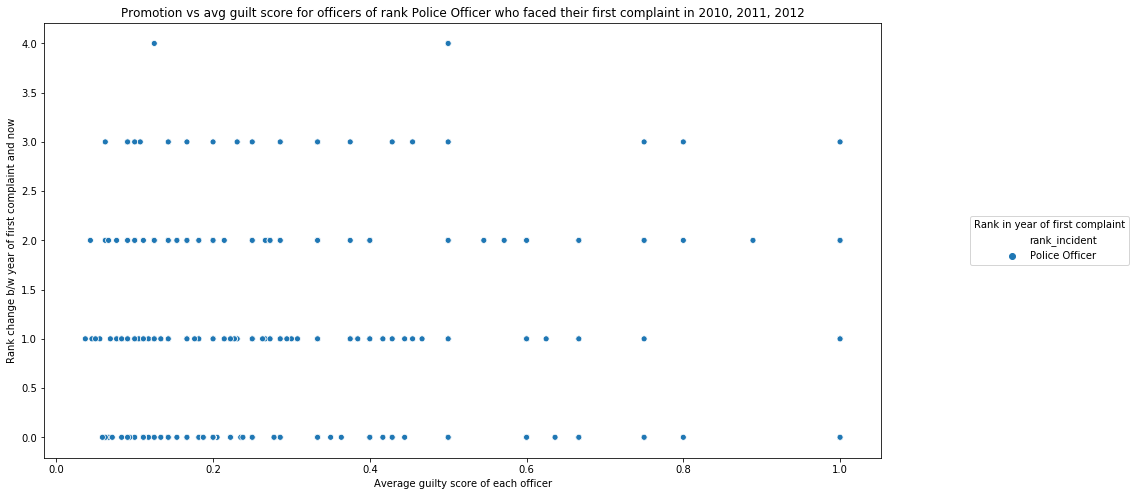

In [157]:
year_received_scatterplot = 2011 # choose any value between 1985 and 2020
rank = 'Police Officer' # choose from: Police Officer,Detective,Sergeant,Lieutenant,Captain, Deputy Inspector, Inspector,
                        #  Chiefs and other ranks
rank_vs_guilt_df = rank_vs_guilt(allegations_df_rank_time, complaints_by_officer_df, year_received_scatterplot, rank)

### Part 7. Visualize changes in ranks of each of the 3996 officers

##### For the initial rank, an officer's rank at the time of the first complaint is chosen
##### Due to this methodology, only the change in rank b/w the time of the first complaint and the current time is visible
##### Diagram generated by this part renders outside the notebook

In [199]:
def visualize_rank_changes(rank_vs_guilt_df, year_received_sankey):
    '''
    visualizes changes in ranks of each of the 3996 officers through a sankey diagram
    '''
    
    # diagram is made for all officers that faced their first complaint in year_received_sankey, and one year before and after that 
    year_ahead = year_received_sankey + 1
    year_behind = year_received_sankey - 1
    
    # the average guilty score (weighted_average_guilt) of a group of officers transitioning between a pair of ranks  
    # (Sergeant - Lieutenant, for example) is calculated as the mean of average guilty scores (avg_guilty_score) of individual 
    # officers weighted by the number of complaints against them (number_of_complaints)
    weighted_mean = lambda x: np.average(x, weights=rank_vs_guilt_df.loc[x.index, "number_of_complaints"])
    
    dictionary = {'unique_mos_id':'size', 'avg_guilty_score': weighted_mean}
    # sankey_df produces numbers on changes between every pair of ranks, which are entered in links (below) to make the diagram 
    sankey_df = rank_vs_guilt_df[(rank_vs_guilt_df['year_received'] == year_received_sankey) | (rank_vs_guilt_df['year_received'] \
               == year_ahead) | (rank_vs_guilt_df['year_received'] == year_behind)].groupby(['rank_incident', 'rank_now'],\
               as_index=False).agg(dictionary).rename(columns = {'unique_mos_id':'number_of_officers', 'avg_guilty_score': \
                                                                                               'weighted_average_guilt'})
    
    # assign numerals to current rank and rank at the time of the first complaint for every officer 
    sankey_df.loc[sankey_df['rank_incident'] == 'Police Officer', 'numeric_rank_incident'] = 0
    sankey_df.loc[sankey_df['rank_incident'] == 'Detective', 'numeric_rank_incident'] = 1
    sankey_df.loc[sankey_df['rank_incident'] == 'Sergeant', 'numeric_rank_incident'] = 2
    sankey_df.loc[sankey_df['rank_incident'] == 'Lieutenant', 'numeric_rank_incident'] = 3
    sankey_df.loc[sankey_df['rank_incident'] == 'Captain', 'numeric_rank_incident'] = 4
    sankey_df.loc[sankey_df['rank_incident'] == 'Deputy Inspector', 'numeric_rank_incident'] = 5
    sankey_df.loc[sankey_df['rank_incident'] == 'Inspector', 'numeric_rank_incident'] = 6
    sankey_df.loc[sankey_df['rank_incident'] == 'Chiefs and other ranks', 'numeric_rank_incident'] = 7
    
    sankey_df.loc[sankey_df['rank_now'] == 'Police Officer', 'numeric_rank_now'] = 8
    sankey_df.loc[sankey_df['rank_now'] == 'Detective', 'numeric_rank_now'] = 9
    sankey_df.loc[sankey_df['rank_now'] == 'Sergeant', 'numeric_rank_now'] = 10
    sankey_df.loc[sankey_df['rank_now'] == 'Lieutenant', 'numeric_rank_now'] = 11
    sankey_df.loc[sankey_df['rank_now'] == 'Captain', 'numeric_rank_now'] = 12
    sankey_df.loc[sankey_df['rank_now'] == 'Deputy Inspector', 'numeric_rank_now'] = 13
    sankey_df.loc[sankey_df['rank_now'] == 'Inspector', 'numeric_rank_now'] = 14
    sankey_df.loc[sankey_df['rank_now'] == 'Chiefs and other ranks', 'numeric_rank_now'] = 15

    # links and nodes are created for the sankey diagram
    links = [[]]
    index = 0
    number_of_colours = len(sankey_df)
    colours = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colours)]

    for rank_i, rank_n, value, avg in zip(sankey_df['numeric_rank_incident'].values, 
                                     sankey_df['numeric_rank_now'].values, 
                                     sankey_df['number_of_officers'].values, sankey_df['weighted_average_guilt'].values):
        colour = colours[index]
        rank_list = [rank_i, rank_n, value, round(avg,2), colour]
        links.insert(index, rank_list)
        index = index + 1
    
    nodes = [[0,'Police Officer','#4994CE'],
        [1,'Detective','#8A5988'],
        [2,'Sergeant','#A0522D'],
        [3,'Lieutenant','#ffe873'],
        [4,'Captain','#646464'],
        [5,'Deputy Inspector','#449E9E'],
        [6,'Inspector',' #306998'],
        [7,'Chiefs and other ranks','#ffd43b'],
        [8,'Police Officer','#4994CE'],
        [9,'Detective','#8A5988'],
        [10,'Sergeant','#A0522D'],
        [11,'Lieutenant','#ffe873'],
        [12,'Captain','#646464'],
        [13,'Deputy Inspector','#449E9E'],
        [14,'Inspector',' #306998'],
        [15,'Chiefs and other ranks','#ffd43b'],]
    
    df_nodes = pd.DataFrame(nodes, columns = ['ID', 'Label', 'Colour'])
    df_links = pd.DataFrame(links, columns = ['Source', 'Target', 'Value', 'weighted_average_guilt', 'Link Colour'])

    data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Colour']
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Colour'].dropna(axis=0, how='any'),
      label= df_links['weighted_average_guilt'].dropna(axis=0, how='any'),
    )
    )

    layout = dict(
        title = "Change in ranks and average guilty scores of officers who faced their first complaint in the years {}, {}, {}".format(year_behind, year_received_sankey, year_ahead),
    height = 772,
    font = dict(
      size = 10),)
    
    fig = dict(data=[data_trace], layout=layout)
    plotly.offline.plot(fig, validate=False, image = 'png', image_filename='Change in ranks', output_type='file', image_width=1000,\
                        image_height=720, filename='temp-plot.html')

In [200]:
year_received_sankey = 2005 # choose any value between 1985 and 2020
visualize_rank_changes(rank_vs_guilt_df, year_received_sankey)

### Part 8: Are Black people singled out for certain offences?

##### Contrary to intuition, Black people don't have a particularly high share of complaints for offences such as parking violation
##### For Stop/Question/Frisk, 100% of complaints come from Black people, but this is from a sample of just 4 (the rest 202 are NaN)

In [112]:
def offences_by_race(allegations_df, reason):
    '''
    plots a pie chart to show distribution of chosen offence (contact_reason) by race of complainants
    '''
    contact_by_ethnicity_df = allegations_df[(allegations_df['contact_reason'] == reason)].groupby('complainant_ethnicity').size() \
    .reset_index(name = 'number_of_complaints')
    
    ax = plt.subplot(121, aspect='equal')
    ax.pie(contact_by_ethnicity_df['number_of_complaints'], autopct='%.0f%%',  startangle=10, labeldistance=1.2)
    ax.axis('equal')
    
    plt.legend(labels = contact_by_ethnicity_df['complainant_ethnicity'], loc="best")
    plt.tight_layout()
    plt.title("Share of complaints by ethnicity for contact reason {}".format(reason), bbox={'facecolor':'0.8', 'pad':6})
    
    ax = plt.gcf()
    ax.set_size_inches(14,10)
    
    plt.show()

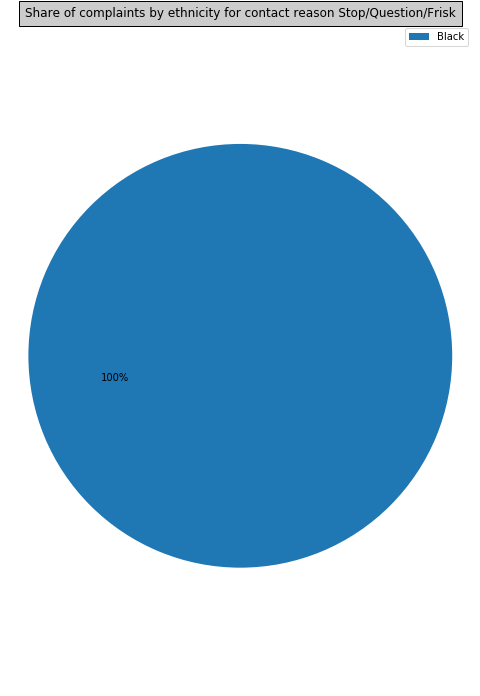

In [168]:
reason = 'Stop/Question/Frisk' # the cell below has a list of reasons to choose from
offences_by_race(allegations_df, reason)

##### list of reasons: 
        'Report-domestic dispute', 'Moving violation',
       'PD suspected C/V of violation/crime - street', 'Report-dispute',
       'C/V telephoned PCT', 'Other', 'Regulatory inspection',
       'Other violation of VTL', 'Parking violation',
       'Execution of search warrant',
       'PD suspected C/V of violation/crime - bldg', nan,
       'Execution of arrest/bench warrant',
       'PD suspected C/V of violation/crime - auto',
       'Report-possession/sale of narcotics', 'Report-noise/disturbance',
       'C/V intervened on behalf of/observed encounter w/3rd party',
       'Traffic accident', 'Aided case', 'EDP aided case',
       'C/V at PCT to file complaint of crime', 'Report of other crime',
       'PD auto checkpoint', 'Demonstration/protest',
       'Arrest/Complainant', 'C/V requested investigation of crime',
       'Assist ACS or other agency', 'C/V at PCT to obtain information',
       'CV already in custody', 'Report-gun possession/shots fired',
       'Traffic Incidents/Accident/Prk Violation', 'Stop/Question/Frisk',
       'Complainant at Pct. to make a Cmpl/info',
       'Vehicle Stop and Check', 'C/V requested info from officer',
       'PD suspected C/V of violation/crime - subway',
       'Telephone Call to Precinct/Command', 'Patrol Encounter', 'Others',
       'Arrest/Not Complainant', 'Dispute',
       'Report of Crime Past/Present', 'Summons/Complainant',
       'Complainant Witnessing Incident',
       'C/V at PCT to retrieve property',
       'Report of Disturbance/Noise Complaint', 'Parade/special event',
       'PD telephones CV', 'EDP Aided Cases', 'Aided Cases',
       'Demonstrations', 'Transit checkpoint',
       'Victim Subject of Sex Crime', 'No contact'

### Part 9: How often have cops been accused of chokehold/restricting breathing, and by which races?

##### Less than 1% complaints pertain to either chokehold or restricted breathing, and 61% of those are by Black People (similar to their overall share)

In [113]:
def allegation_by_ethnicity(allegations_df, allegation1, allegation2):
    '''
    creates pie chart showing distribution of chokehold/restricted breathing by race
    '''
    
    allegation_by_ethnicity_df = allegations_df[(allegations_df['allegation'] == allegation1) | (allegations_df['allegation'] == \
                              allegation1)].groupby('complainant_ethnicity').size().reset_index(name = 'number_of_complaints')
    
    print(blue("Dropping NaN, the total number of complaints against either chokehold or restricted breathing are {}\n", ['bold']) \
          .format(allegation_by_ethnicity_df['number_of_complaints'].sum()))
    
    ax = plt.subplot(121, aspect='equal')
    ax.pie(allegation_by_ethnicity_df['number_of_complaints'], autopct='%.0f%%',  startangle=10, labeldistance=1.2)
    ax.axis('equal')
    
    plt.legend(labels = allegation_by_ethnicity_df['complainant_ethnicity'], loc="best")
    plt.tight_layout()    
    plt.title("Share of chokehold/restricted breathing by ethnicity", bbox={'facecolor':'0.8', 'pad':6})
    
    ax = plt.gcf()
    ax.set_size_inches(14,10)
    
    plt.show()

Dropping NaN, the total number of complaints against either chokehold or restricted breathing are 243



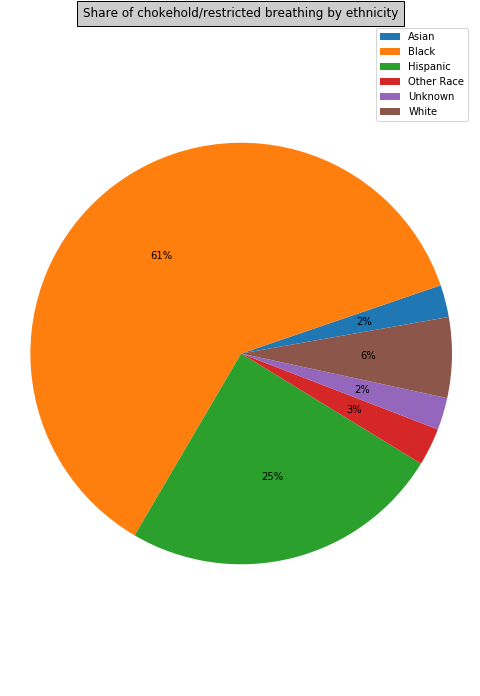

In [166]:
allegation1 = 'Chokehold' # the cell below has a list of allegations to choose from; 
                          # you could choose only one allegation by modifying the code to drop the parameter allegation 2
allegation2 = 'Restricted Breathing'
allegation_by_ethnicity(allegations_df, allegation1, allegation2)

##### list of allegations: 
       'Failure to provide RTKA card', 'Action', 'Race', 'Question',
       'Physical force', 'Refusal to process civilian complaint',
       'Sexual orientation', 'Word', 'Refusal to provide shield number',
       'Retaliatory summons', 'Refusal to provide name/shield number',
       'Search (of person)', 'Pepper spray', 'Handcuffs too tight',
       'Frisk', 'Vehicle stop', 'Vehicle search', 'Strip-searched',
       'Threat of arrest', 'Threat of force (verbal or physical)', 'Stop',
       'Refusal to obtain medical treatment',
       'Hit against inanimate object', 'Frisk and/or search', 'Other',
       'Question and/or stop', 'Premises entered and/or searched',
       'Gun Drawn', 'Nonlethal restraining device', 'Retaliatory arrest',
       'Seizure of property', 'Chokehold', 'Gender',
       'Nightstick as club (incl asp & baton)', 'Refusal to provide name',
       'Gun Pointed', 'Threat to notify ACS',
       'Other blunt instrument as a club', 'Property damaged',
       'Interference with recording', 'Refusal to show search warrant',
       'Threat to damage/seize property', 'Gesture',
       'Sex Miscon (Sexual Harassment, Verbal)',
       'Sex Miscon (Sexual Harassment, Gesture)',
       'Forcible Removal to Hospital', 'Entry of Premises', 'Ethnicity',
       'Threat of summons', 'Other - Force', 'Search of Premises',
       'Threat re: removal to hospital', 'Vehicle',
       'Photography/Videography', 'Demeanor/tone', 'Curse',
       'Dragged/Pulled', 'Push/Shove', 'Detention', 'Other- Discourtesy',
       'Mace', 'Restricted Breathing', 'Body Cavity Searches',
       'Flashlight as club', 'Electronic device information deletion',
       'Search of recording device', 'Gun as club', 'Nasty Words',
       'Radio As Club', 'Threat of force', 'Nightstick/Billy/Club',
       'Black', 'Property Damaged', 'Other - Abuse', 'Property Seized',
       'Threat to Property', 'Religion', 'Hispanic',
       'Sexual Misconduct (Sexual Humiliation)', 'Punch/Kick',
       'Threat of Arrest', 'Beat', 'Gun fired', 'Other - Ethnic Slur',
       'Flashlight As Club', 'Sex Miscon (Sexual/Romantic Proposition)',
       'Gun pointed/gun drawn', 'Radio as club',
       'Improper dissemination of medical info', nan, 'Person Searched',
       'Physical disability', 'Arrest/Onlooker',
       'Failed to Obtain Language Interpretation', 'Rude Gesture',
       'Jewish', 'Vehicle Searched', 'Gay/Lesbian Slur',
       'Premise Searched', 'Arrest/D. A. T.', 'Oriental', 'Sh Refuse Cmp',
       'Slap', 'Gun As Club', 'Police shield', 'Threat of Summons',
       'White', 'Gun pointed', 'Profane Gesture',
       'Refusal to show arrest warrant', 'Sexist Remark', 'Other Asian',
       'Animal', 'Gun Fired', 'Questioned immigration status',
       'Gender Identity'

### Part 10: Does the board's decision depend on the race of the complainant and the officer?

##### The results are quite striking: American Indians, officers as well as complainants, enjoy a distinct advantage over other races.
##### The board is more likely to acquit American Indian officers, and determine guilt in complaints filed by American Indian complainants

In [114]:
def board_decision_race(allegations_df):
    '''
    creates and merges dataframes containing average guilty scores (as calcultated in the function numeric_board_disposition) 
    by race of officer and complainant, and plots them
    '''
    
    # average guilty scores by race of officer 
    off_ethnicity_guilty_df = allegations_df.groupby('mos_ethnicity')['numeric_board_finding'].mean().reset_index(name = \
                                         'avg_guilty_score_off').sort_values('avg_guilty_score_off', ascending=False)
    
    # avrage guilty scores by race of complainant
    com_ethnicity_guilty_df = allegations_df.groupby('complainant_ethnicity')['numeric_board_finding'].mean().reset_index(name = \
                                                                                                'avg_guilty_score_com')
    
    # merge the two to make a pie chart
    ethnicity_guilty_merge_df = pd.merge(off_ethnicity_guilty_df, com_ethnicity_guilty_df, left_on='mos_ethnicity', right_on= \
                                         'complainant_ethnicity', how = 'inner')
    
    # plot pie chart
    x = np.arange(5)
    w = 0.3
    ax1 = plt.subplot(1,1,1)
    plt.xticks(x + w /2, ethnicity_guilty_merge_df['mos_ethnicity'], rotation='vertical')
    plt.title("Proportion of complaints found guilty by race")
    officer = ax1.bar(x, ethnicity_guilty_merge_df['avg_guilty_score_off'], color='#4994CE', width=w, align='center')
    
    ax2 = ax1.twinx()
    
    complainant = ax2.bar(x + w, ethnicity_guilty_merge_df['avg_guilty_score_com'], color='#A0522D', width=w, align='center')
    plt.legend([officer, complainant], ['Officer Race', 'Complainant Race'], loc="best", bbox_to_anchor=(1.1, 0.5))
    
    ax1.grid(False)
    ax2.grid(False)
    ax2.set_yticks([10], minor = False)
    
    plt.show()

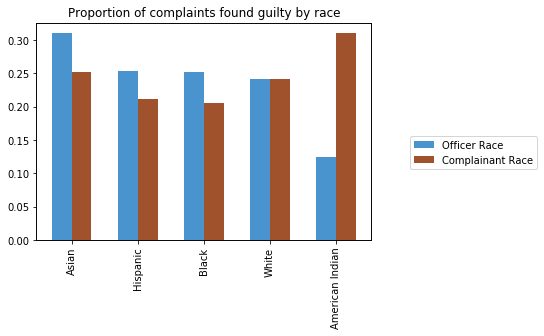

In [161]:
board_decision_race(allegations_df_rank_board)

##### Assign numerical values to officer ranks

In [115]:
def numeric_rank(allegations_df):
    '''
    assigns numeric values to ranks at the time of complaint and at the current time, and calculates the difference
    b/w them
    '''
    # new column for numeric rank at the time of complaint
    allegations_df.loc[allegations_df['rank_incident'] == 'Police Officer', 'numeric_rank_incident'] = 0
    allegations_df.loc[allegations_df['rank_incident'] == 'Detective', 'numeric_rank_incident'] = 1
    allegations_df.loc[allegations_df['rank_incident'] == 'Sergeant', 'numeric_rank_incident'] = 2
    allegations_df.loc[allegations_df['rank_incident'] == 'Lieutenant', 'numeric_rank_incident'] = 3
    allegations_df.loc[allegations_df['rank_incident'] == 'Captain', 'numeric_rank_incident'] = 4
    allegations_df.loc[allegations_df['rank_incident'] == 'Deputy Inspector', 'numeric_rank_incident'] = 5
    allegations_df.loc[allegations_df['rank_incident'] == 'Inspector', 'numeric_rank_incident'] = 6
    allegations_df.loc[allegations_df['rank_incident'] == 'Chiefs and other ranks', 'numeric_rank_incident'] = 7
    
    # new column for numeric rank at the current time
    allegations_df.loc[allegations_df['rank_now'] == 'Police Officer', 'numeric_rank_now'] = 0
    allegations_df.loc[allegations_df['rank_now'] == 'Detective', 'numeric_rank_now'] = 1
    allegations_df.loc[allegations_df['rank_now'] == 'Sergeant', 'numeric_rank_now'] = 2
    allegations_df.loc[allegations_df['rank_now'] == 'Lieutenant', 'numeric_rank_now'] = 3
    allegations_df.loc[allegations_df['rank_now'] == 'Captain', 'numeric_rank_now'] = 4
    allegations_df.loc[allegations_df['rank_now'] == 'Deputy Inspector', 'numeric_rank_now'] = 5
    allegations_df.loc[allegations_df['rank_now'] == 'Inspector', 'numeric_rank_now'] = 6
    allegations_df.loc[allegations_df['rank_now'] == 'Chiefs and other ranks', 'numeric_rank_now'] = 7
    
    # new column to calculate difference in numeric ranks
    allegations_df['numeric_rank_change'] = allegations_df['numeric_rank_now'] - allegations_df['numeric_rank_incident']
    
    return allegations_df

##### Assign numerical values to findings of the Board

In [116]:
def numeric_board_disposition(allegations_df):
    '''
    makes a new column, board_finding, that creates one category for Unsubstantiated and Exonerated, and another for all 
    different forms of Substantiated; numeric_board_finding assigns 0 to Unsubstantiated/Exonerated category, and 1 to Substantiated category
    '''
    
    for idx, finding in enumerate(allegations_df.board_disposition.values):
        word = re.findall("^(Substantiated)", finding)
        if word == ['Substantiated']:
            allegations_df.loc[idx, 'board_finding'] = word
        else:
            allegations_df.loc[idx, 'board_finding'] = 'Unsubstantiated or exonerated'
    
    allegations_df.loc[allegations_df['board_finding'] == 'Unsubstantiated or exonerated', 'numeric_board_finding'] = 0
    allegations_df.loc[allegations_df['board_finding'] == 'Substantiated', 'numeric_board_finding'] = 1
    
    return allegations_df